# TA-Lib Candlestick Scanner + Backtester (Swing Trading)

This notebook:
1) **Scans** your tickers for classic **TA-Lib** candlestick patterns (Daily or 4H), with swing-friendly **trend filters**.
2) **Backtests** those signals with **ATR-based** stop/target, fees, slippage, and position sizing.

**Patterns covered**
- **Bullish:** Bullish Engulfing, Morning Star, Hammer, Piercing Line, Three White Soldiers, Bullish Harami  
- **Bearish:** Bearish Engulfing, Evening Star, Shooting Star, Dark Cloud Cover, Three Black Crows, Bearish Harami

**Outputs**
- Results table with: **Stock Symbol**, **Pattern Detected**, **Bullish/Bearish**, **When this pattern usually forms**
- CSV exports: `talib_candlestick_scan_<timeframe>.csv`, `bt_trades.csv`
- Performance metrics + plots (equity curve, trade return distribution)

> TA-Lib returns +/– values; positive usually means bullish, negative bearish.


## 1) Setup
If TA-Lib fails to install via pip, install the **system library** first:
- macOS: `brew install ta-lib`
- Ubuntu/Debian: `sudo apt-get install -y ta-lib`
- Windows: use prebuilt wheels or an environment that already includes TA-Lib.


In [41]:
import sys, subprocess, importlib

def ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
        print(f"OK: {pkg}")
    except ImportError:
        name = pip_name or pkg
        print(f"Installing {name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

for p in ["yfinance", "pandas", "numpy", "matplotlib"]:
    ensure(p)

# TA-Lib
try:
    import talib as ta
    print("OK: TA-Lib available")
except Exception:
    print("TA-Lib not found, attempting pip install...")
    ensure("talib", "TA-Lib")
    import talib as ta

import pandas as pd
import numpy as np
import yfinance as yf
import math
import json
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 160)

OK: yfinance
OK: pandas
OK: numpy
OK: matplotlib
OK: TA-Lib available


## 2) Parameters

Edit the parameters below to suit your universe and preferences.


In [42]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# SYMBOLS & TIMEFRAME
symbols = ['RELIANCE.NS']
timeframe = "1d"              # '1d' (Daily) or '4h' (4-Hour)
lookback_days = 60 #1825          # For daily only (approx 5 years)

# SCANNER
recent_window = 3             # Look for signals in last N candles
use_trend_filter_scanner = True  # Bullish only after downtrend, bearish only after uptrend

# BACKTEST
signal_set = "bullish"        # 'bullish', 'bearish', or 'both'
use_trend_filter_backtest = True
allow_shorts = True          # For equities, default long-only

# ATR risk model
atr_period = 14
atr_sl_mult = 2.0             # Stop distance = SL mult * ATR
atr_tp_mult = 2.0             # Take profit distance = TP mult * ATR

# Portfolio & trading
initial_equity = 100000.0
risk_per_trade_pct = 1.0      # % of equity allocated per trade (simple sizing)
fees_bps_per_side = 10.0      # 10 bps = 0.10% per side
slippage_bps_per_side = 5.0   # 5 bps = 0.05% per side
max_holding_bars = 20         # Time stop if neither SL nor TP is hit
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

assert timeframe in ("1d", "4h")
assert signal_set in ("bullish", "bearish", "both")

## 3) Helpers

In [43]:
def yf_params(timeframe: str, lookback_days: int):
    if timeframe == "1d":
        period = f"{min(max(lookback_days, 2), 3650)}d"  # up to 10y
        interval = "1d"
    else:
        period = "60d"   # yfinance intraday reliable max for 4H
        interval = "4h"
    return dict(period=period, interval=interval)

def fetch_ohlc(ticker: str, period: str, interval: str) -> pd.DataFrame:
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=False, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs(ticker, axis=1, level=1)
        except Exception:
            pass
    df = df.rename(columns={c: c.title() for c in df.columns})
    df = df.dropna()
    return df

def slope(series: pd.Series, window: int = 5) -> float:
    if len(series) < window:
        return 0.0
    y = series.tail(window).values.astype(float)
    x = np.arange(len(y))
    m = np.polyfit(x, y, 1)[0]
    return float(m)

def series_slope(series: pd.Series, window: int = 5) -> pd.Series:
    # Rolling slope over 'window' bars
    return series.rolling(window).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

def in_downtrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl < 0) & (close < sma20)

def in_uptrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl > 0) & (close > sma20)

def in_downtrend_now(df: pd.DataFrame, window: int = 5) -> bool:
    if len(df) < max(20, window):
        return False
    sma20 = df['Close'].rolling(20).mean().iloc[-1]
    return slope(df['Close'], window) < 0 and df['Close'].iloc[-1] < (sma20 if pd.notna(sma20) else df['Close'].iloc[-1])

def in_uptrend_now(df: pd.DataFrame, window: int = 5) -> bool:
    if len(df) < max(20, window):
        return False
    sma20 = df['Close'].rolling(20).mean().iloc[-1]
    return slope(df['Close'], window) > 0 and df['Close'].iloc[-1] > (sma20 if pd.notna(sma20) else df['Close'].iloc[-1])

## 4) TA-Lib Pattern Signals

In [44]:
import talib as ta

BULLISH_NAMES = ["Bullish Engulfing","Morning Star","Hammer","Piercing Line","Three White Soldiers","Bullish Harami"]
BEARISH_NAMES = ["Bearish Engulfing","Evening Star","Shooting Star","Dark Cloud Cover","Three Black Crows","Bearish Harami"]

PATTERN_CONTEXT = {
    "Bullish Engulfing": "End of a **downtrend**; strong green candlestick engulfing prior body — **bullish reversal** potential.",
    "Morning Star": "After a **downtrend**: red, small 'star', then strong green — **reversal** pattern.",
    "Hammer": "At/near end of a **downtrend**; long lower shadow shows **rejection of lows**.",
    "Piercing Line": "Following a **downtrend**; gap-down open then close above prior midpoint — **reversal**.",
    "Three White Soldiers": "Three strong advances after weakness — **bullish reversal/continuation**.",
    "Bullish Harami": "Small green within a large red after a **downtrend** — **reversal** potential.",
    "Bearish Engulfing": "After an **uptrend**; large red engulfing prior body — **bearish reversal**.",
    "Evening Star": "After an **uptrend**: green, small 'star', then strong red — **reversal**.",
    "Shooting Star": "At/near end of an **uptrend**; long upper shadow shows **rejection of highs**.",
    "Dark Cloud Cover": "After an **uptrend**; gap-up then close below prior midpoint — **reversal**.",
    "Three Black Crows": "Three strong declines after strength — **bearish reversal/continuation**.",
    "Bearish Harami": "Small red within a large green after an **uptrend** — **reversal** potential.",
}

def talib_signals(df: pd.DataFrame) -> pd.DataFrame:
    o = df['Open'].values.astype(float)
    h = df['High'].values.astype(float)
    l = df['Low'].values.astype(float)
    c = df['Close'].values.astype(float)

    out = {}
    out["Bullish Engulfing"] = ta.CDLENGULFING(o,h,l,c)
    out["Bearish Engulfing"] = out["Bullish Engulfing"]   # sign matters

    out["Morning Star"] = ta.CDLMORNINGSTAR(o,h,l,c)
    out["Evening Star"] = ta.CDLEVENINGSTAR(o,h,l,c)

    out["Hammer"] = ta.CDLHAMMER(o,h,l,c)
    out["Shooting Star"] = ta.CDLSHOOTINGSTAR(o,h,l,c)

    out["Piercing Line"] = ta.CDLPIERCING(o,h,l,c)
    out["Dark Cloud Cover"] = ta.CDLDARKCLOUDCOVER(o,h,l,c)

    out["Three White Soldiers"] = ta.CDL3WHITESOLDIERS(o,h,l,c)
    out["Three Black Crows"]   = ta.CDL3BLACKCROWS(o,h,l,c)

    out["Bullish Harami"] = ta.CDLHARAMI(o,h,l,c)
    out["Bearish Harami"] = out["Bullish Harami"]         # sign matters

    sig = pd.DataFrame(out, index=df.index)

    # Normalize to +1/-1/0
    for col in sig.columns:
        sig[col] = np.where(sig[col] > 0, 1, np.where(sig[col] < 0, -1, 0))

    return sig

def combined_signal(df: pd.DataFrame, sig: pd.DataFrame, use_trend=True, choose="both") -> pd.Series:
    bull = pd.Series(0, index=df.index)
    bear = pd.Series(0, index=df.index)

    if choose in ("bullish","both"):
        bull_series = pd.Series(0, index=df.index)
        for name in BULLISH_NAMES:
            s = sig[name]
            if name == "Bullish Harami":
                s = (sig["Bullish Harami"] > 0).astype(int)  # +1 only
            elif name == "Bullish Engulfing":
                s = (sig["Bullish Engulfing"] > 0).astype(int)
            else:
                s = (s > 0).astype(int)
            bull_series = bull_series | (s == 1)
        if use_trend:
            down = in_downtrend_series(df)
            bull = ((bull_series == 1) & down.fillna(False)).astype(int)
        else:
            bull = (bull_series == 1).astype(int)

    if choose in ("bearish","both"):
        bear_series = pd.Series(0, index=df.index)
        for name in BEARISH_NAMES:
            s = sig[name]
            if name == "Bearish Harami":
                s = (sig["Bearish Harami"] < 0).astype(int)  # -1 only
            elif name == "Bearish Engulfing":
                s = (sig["Bearish Engulfing"] < 0).astype(int)
            else:
                s = (s < 0).astype(int)
            bear_series = bear_series | (s == 1)
        if use_trend:
            up = in_uptrend_series(df)
            bear = ((bear_series == 1) & up.fillna(False)).astype(int) * -1
        else:
            bear = (bear_series == 1).astype(int) * -1

    return bull.add(bear, fill_value=0).astype(int)  # +1, -1, or 0

## 5) Scanner (Fresh Signals)

In [45]:
def find_latest_signal(df: pd.DataFrame, recent_window: int = 3, use_trend=True):
    if len(df) < 30:
        return None

    sig_all = talib_signals(df)
    # Build bullish/bearish combined series, but we want to keep the **pattern name** too.
    # We'll search each pattern individually for the last N bars.
    patterns = BULLISH_NAMES + BEARISH_NAMES

    down_now = in_downtrend_now(df) if use_trend else True
    up_now = in_uptrend_now(df) if use_trend else True

    best = None  # (name, idx, side, value)

    for name in patterns:
        vals = sig_all[name].values
        start = max(0, len(vals) - recent_window)
        seg_idx = None
        seg_val = None
        for i in range(len(vals)-1, start-1, -1):
            if vals[i] != 0:
                # Trend filter per side
                side = "Bullish" if name in BULLISH_NAMES else "Bearish"
                if use_trend:
                    if side == "Bullish" and not down_now:
                        continue
                    if side == "Bearish" and not up_now:
                        continue
                seg_idx = i
                seg_val = vals[i]
                break
        if seg_idx is None:
            continue
        if (best is None) or (seg_idx > best[1]):
            side = "Bullish" if name in BULLISH_NAMES else "Bearish"
            best = (name, seg_idx, side, int(seg_val))

    if best is None:
        return None

    name, idx, side, v = best
    # Ensure Harami sign correctness
    if name == "Bullish Harami" and v < 0: return None
    if name == "Bearish Harami" and v > 0: return None

    return {
        "pattern": name,
        "side": side,
        "index": idx,
        "strength": abs(v),
        "context": PATTERN_CONTEXT[name],
    }

def run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend):
    yfp = yf_params(timeframe, lookback_days)
    rows = []
    for sym in symbols:
        try:
            df = fetch_ohlc(sym, **yfp)
            if df.empty:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", context="No data"))
                continue
            sig = find_latest_signal(df, recent_window=recent_window, use_trend=use_trend)
            if sig is None:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", context="—"))
            else:
                rows.append(dict(symbol=sym, pattern=sig['pattern'], side=sig['side'], context=sig['context']))
        except Exception as e:
            rows.append(dict(symbol=sym, pattern="Error", side="", context=str(e)))
    res = pd.DataFrame(rows, columns=["symbol","pattern","side","context"])
    return res

scan_results = run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend_filter_scanner)
scan_results = scan_results.rename(columns={
    "symbol":"Stock Symbol",
    "pattern":"Pattern Detected",
    "side":"Bullish/Bearish",
    "context":"When this pattern usually forms"
})
scan_results

,Stock Symbol,Pattern Detected,Bullish/Bearish,When this pattern usually forms
0,RELIANCE.NS,No clear setup,,—


In [46]:
# Save scan results
scan_csv = f"talib_candlestick_scan_{timeframe}.csv"
scan_results.to_csv(scan_csv, index=False)
print(f"Saved scan CSV: {scan_csv}")

bullish_list = scan_results[scan_results["Bullish/Bearish"]=="Bullish"]["Stock Symbol"].tolist()
bearish_list = scan_results[scan_results["Bullish/Bearish"]=="Bearish"]["Stock Symbol"].tolist()

print("\nScanner Summary:")
print("• Bullish swing candidates:", ", ".join(bullish_list) if bullish_list else "None")
print("• Bearish / avoid for now:", ", ".join(bearish_list) if bearish_list else "None")

Saved scan CSV: talib_candlestick_scan_1d.csv

Scanner Summary:
• Bullish swing candidates: None
• Bearish / avoid for now: None


## 6) Backtester

In [47]:
def compute_atr(df: pd.DataFrame, period=14) -> pd.Series:
    o = df['Open'].values.astype(float)
    h = df['High'].values.astype(float)
    l = df['Low'].values.astype(float)
    c = df['Close'].values.astype(float)
    atr = ta.ATR(h, l, c, timeperiod=period)
    return pd.Series(atr, index=df.index)

def bps_to_mult(bps: float) -> float:
    return 1.0 + (bps/10000.0)

def first_touch_exit(o, h, l, c, long: bool, stop, target):
    # Return (exit_price, reason) considering bar sequence: open -> high/low -> close
    if long:
        if o <= stop:  # gap below stop
            return float(o), "gap_stop"
        hit_target = h >= target
        hit_stop = l <= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None
    else:
        if o >= stop:  # gap above stop
            return float(o), "gap_stop"
        hit_target = l <= target
        hit_stop = h >= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None

def backtest_symbol(df: pd.DataFrame, signals: pd.Series, params: dict):
    atr = compute_atr(df, period=params['atr_period'])
    trades = []
    equity = params['initial_equity']
    idx_list = list(df.index)
    position = None

    for i in range(len(df)-1):  # evaluate next bar for fills
        ts = idx_list[i]
        nxt_ts = idx_list[i+1]
        nxt = df.loc[nxt_ts]

        # Manage open position
        if position is not None:
            exit_px, reason = first_touch_exit(
                float(nxt['Open']), float(nxt['High']), float(nxt['Low']), float(nxt['Close']),
                long=(position['side'] == 1),
                stop=position['stop'], target=position['target']
            )
            exit_now = False
            if exit_px is not None:
                exit_now = True
            else:
                if (i+1 - position['entry_i']) >= params['max_holding_bars']:
                    exit_px = float(nxt['Close'])
                    reason = "time"
                    exit_now = True

            if exit_now:
                fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])
                if position['side'] == 1:
                    gross = (exit_px / position['entry_fill']) - 1.0
                else:
                    gross = (position['entry_fill'] / exit_px) - 1.0
                gross = (gross + 1.0) / fee_mult - 1.0  # exit costs

                pnl = equity * position['alloc'] * gross
                equity += pnl
                trades.append({
                    "symbol": params['symbol'],
                    "entry_time": position['entry_time'],
                    "exit_time": nxt_ts,
                    "side": "LONG" if position['side']==1 else "SHORT",
                    "entry_price": position['entry_fill'],
                    "exit_price": exit_px,
                    "reason": reason,
                    "bars": (i+1 - position['entry_i']),
                    "gross_ret_pct": gross*100.0,
                    "pnl": pnl,
                    "equity_after": equity
                })
                position = None

        # New entries
        if position is None:
            sig = int(signals.iloc[i])
            if sig == 0:
                continue

            atr_val = float(atr.iloc[i])
            if math.isnan(atr_val) or atr_val <= 0:
                continue

            entry_open = float(nxt['Open'])
            ent_fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])

            if sig == 1:
                stop = entry_open - params['atr_sl_mult'] * atr_val
                target = entry_open + params['atr_tp_mult'] * atr_val
                entry_fill = entry_open * ent_fee_mult
                position = dict(side=1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                                stop=stop, target=target, alloc=(params['risk_per_trade_pct']/100.0))
            elif sig == -1 and params['allow_shorts']:
                stop = entry_open + params['atr_sl_mult'] * atr_val
                target = entry_open - params['atr_tp_mult'] * atr_val
                entry_fill = entry_open / ent_fee_mult  # short
                position = dict(side=-1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                                stop=stop, target=target, alloc=(params['risk_per_trade_pct']/100.0))

    return pd.DataFrame(trades), equity

def portfolio_backtest(data_map, signals_map, params):
    all_trades = []
    per_symbol = {}
    # Equal capital split across symbols for simplicity
    for sym, df in data_map.items():
        lp = params.copy()
        lp['symbol'] = sym
        lp['initial_equity'] = params['initial_equity'] / max(1, len(data_map))
        tdf, final_eq = backtest_symbol(df, signals_map[sym], lp)
        all_trades.append(tdf)
        per_symbol[sym] = dict(trades=tdf, final_equity=final_eq)
    trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(columns=[
        "symbol","entry_time","exit_time","side","entry_price","exit_price","reason","bars","gross_ret_pct","pnl","equity_after"
    ])
    return trades_df, per_symbol

## 7) Run Backtest

In [48]:
# Build data & global signals
yfp = yf_params(timeframe, lookback_days)
data_map, signals_map = {}, {}

for sym in symbols:
    df = fetch_ohlc(sym, **yfp)
    if df.empty or len(df) < 60:
        print(f"Skipping {sym}: insufficient data")
        continue
    sig_all = talib_signals(df)
    sig_comb = combined_signal(df, sig_all, use_trend=use_trend_filter_backtest, choose=signal_set)
    data_map[sym] = df
    signals_map[sym] = sig_comb

params = dict(
    atr_period=atr_period,
    atr_sl_mult=atr_sl_mult,
    atr_tp_mult=atr_tp_mult,
    initial_equity=initial_equity,
    risk_per_trade_pct=risk_per_trade_pct,
    fees_bps_per_side=fees_bps_per_side,
    slippage_bps_per_side=slippage_bps_per_side,
    allow_shorts=allow_shorts,
    max_holding_bars=max_holding_bars
)

trades_df, per_symbol_results = portfolio_backtest(data_map, signals_map, params)

trades_csv = "bt_trades.csv"
trades_df.to_csv(trades_csv, index=False)
print(f"Saved trades: {trades_csv}")
trades_df.tail(10)

Saved trades: bt_trades.csv


,symbol,entry_time,exit_time,side,entry_price,exit_price,reason,bars,gross_ret_pct,pnl,equity_after
0,RELIANCE.NS,2025-07-24,2025-08-07,LONG,1421.328751,1372.712941,stop,10,-3.565100,-35.651003,99964.348997
1,RELIANCE.NS,2025-08-28,2025-09-01,LONG,1391.984874,1347.825972,stop,2,-3.317393,-33.162107,99931.186891


## 8) Performance Metrics

In [49]:
def compute_metrics(trades: pd.DataFrame):
    if trades.empty:
        return {}
    rets = trades['gross_ret_pct'] / 100.0
    wins = rets[rets > 0]
    losses = rets[rets <= 0]

    win_rate = (len(wins) / len(rets)) if len(rets) else 0.0
    avg_win = wins.mean() if len(wins) else 0.0
    avg_loss = losses.mean() if len(losses) else 0.0
    profit_factor = (wins.sum() / abs(losses.sum())) if len(losses) else float('inf')
    expectancy = rets.mean()

    eq = [initial_equity]
    times = []
    for _, r in trades.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    roll_max = equity_series.cummax()
    drawdown = (equity_series - roll_max) / roll_max
    max_dd = drawdown.min() if len(drawdown) else 0.0

    sharpe_like = (rets.mean() / rets.std() * np.sqrt(len(rets))) if rets.std() > 0 else 0.0

    return {
        "trades": int(len(trades)),
        "win_rate": float(win_rate),
        "avg_win": float(avg_win),
        "avg_loss": float(avg_loss),
        "profit_factor": float(profit_factor),
        "expectancy_per_trade": float(expectancy),
        "max_drawdown_pct": float(max_dd * 100.0),
        "sharpe_like": float(sharpe_like),
        "final_equity": float(equity_series.iloc[-1]) if len(equity_series) else float(initial_equity)
    }

metrics = compute_metrics(trades_df)
print(json.dumps(metrics, indent=2))

{
  "trades": 2,
  "win_rate": 0.0,
  "avg_win": 0.0,
  "avg_loss": -0.034412468089771775,
  "profit_factor": 0.0,
  "expectancy_per_trade": -0.034412468089771775,
  "max_drawdown_pct": -3.3173933525766586,
  "sharpe_like": -27.784826592556517,
  "final_equity": 93235.77478126198
}


## 9) Plots (Equity & Return Distribution)

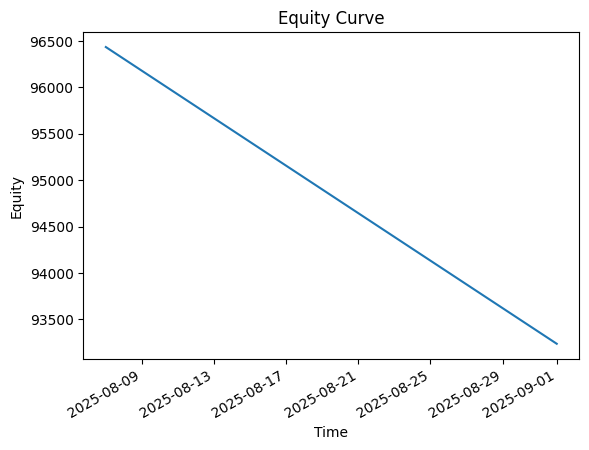

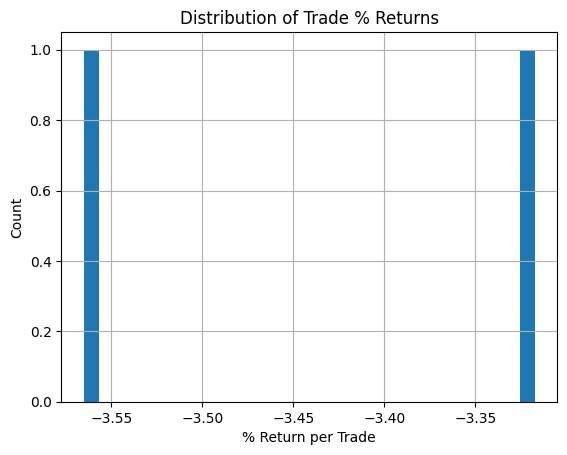

In [50]:
# Equity curve
if not trades_df.empty:
    eq = [initial_equity]
    times = []
    for _, r in trades_df.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    plt.figure()
    equity_series.plot()
    plt.title("Equity Curve")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.show()

    # Trade % return distribution
    plt.figure()
    (trades_df['gross_ret_pct']).hist(bins=30)
    plt.title("Distribution of Trade % Returns")
    plt.xlabel("% Return per Trade")
    plt.ylabel("Count")
    plt.show()

### Notes
- Scanner uses **last N bars** to find fresh signals; backtest uses the **entire history**.
- Conservative assumption on same-bar SL/TP collisions (assumes **stop first**).
- Tune `atr_sl_mult`, `atr_tp_mult`, `max_holding_bars`, fees/slippage to your market.
- For a portfolio that caps simultaneous positions (e.g., max 5 open), extend the backtester to merge trades chronologically and manage allocations globally.
